# PARTE 1
## Exploración de datos

In [2]:
%pip install scikit-learn
# necesario porque de otra forma no me deja usar sklearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
import re
from urllib.parse import urlparse, parse_qs
import math
import seaborn as sns

In [4]:
df = pd.read_csv('dataset_pishing.csv')
df

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate
...,...,...
11425,http://www.fontspace.com/category/blackletter,legitimate
11426,http://www.budgetbots.com/server.php/Server%20...,phishing
11427,https://www.facebook.com/Interactive-Televisio...,legitimate
11428,http://www.mypublicdomainpictures.com/,legitimate


In [5]:
df.head()

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


In [6]:
print(df['status'].value_counts())
print(df['status'].value_counts(normalize=True))

status
legitimate    5715
phishing      5715
Name: count, dtype: int64
status
legitimate    0.5
phishing      0.5
Name: proportion, dtype: float64


## Derivación de características
### Atributos del URL a agregar

**Generales**
- length_url - Longitud total de la URL
- num_dots_url - Cantidad de puntos "." en la URL
- num_hyph_url - Cantidad de guiones "-" en la URL
- num_slash_url - Cantidad de barras "/" en la URL
- num_special_chars_url - Total de caracteres especiales (@, ?, =, &, !, %, $, #, +, *, ~)

**Específicas del dominio**
- length_dom - Longitud del dominio
- num_dots_dom - Cantidad de puntos en el dominio (subdominios)
- dom_in_ip - Si el dominio está en formato IP (binaria)
- num_tld_url - Longitud del TLD (top level domain)

**Específicas del pathname**
- length_path - Longitud del path/pathname
- num_hyph_path - Cantidad de guiones en el path

**De parámetros**
- num_param - Número de parámetros (después de "?")
- length_param - Longitud total de los parámetros

**Características de Entropía**
- shannon_entropy - Entropía de Shannon de la URL
- relative_entropy - Entropía relativa (KL divergence)

## Preprocesamiento

In [7]:
SPECIAL_CHARS = "@?=&!%$#+*~"
def safe_urlparse(u):
    if pd.isna(u):
        return urlparse("")
    u = str(u).strip()
    if not u.startswith(("http://", "https://")):
        u = "http://" + u
    return urlparse(u)


def count_char(s, char):
    if s is None:
        return 0
    return str(s).count(char)


def count_special_chars(s):
    if s is None:
        return 0
    s = str(s)
    return sum(1 for c in s if c in SPECIAL_CHARS)


def is_ip_domain(domain):
    if domain is None:
        return 0
    domain = str(domain)

    # IPv4 simple
    pattern = r"^\d{1,3}(\.\d{1,3}){3}$"
    if re.match(pattern, domain):
        # validación básica 0-255
        parts = domain.split(".")
        for p in parts:
            if int(p) < 0 or int(p) > 255:
                return 0
        return 1
    return 0


def get_tld_length(domain):
    """
    Devuelve longitud del TLD.
    Ej: google.com -> com (3)
        something.co.uk -> uk (2)  (ojo: no detecta TLD compuesto)
    """
    if not domain:
        return 0
    parts = domain.split(".")
    if len(parts) < 2:
        return 0
    return len(parts[-1])

In [8]:
def shannon_entropy(s):
    # Entropía de Shannon: -sum(p_i log2 p_i)
    if s is None:
        return 0.0
    s = str(s)
    if len(s) == 0:
        return 0.0

    freq = {}
    for c in s:
        freq[c] = freq.get(c, 0) + 1

    ent = 0.0
    for count in freq.values():
        p = count / len(s)
        ent -= p * math.log2(p)

    return ent


def relative_entropy_kl(s):
    # Entropía relativa aproximada (KL divergence) contra una distribución uniforme.
    # - Se usa alfabeto basado en caracteres presentes en el string.
    # - KL(P || U) = sum(p_i log2(p_i / u_i))
    # donde U es uniforme (1/k).

    # Nota: esta implementación es una aproximación común para tareas académicas.
    if s is None:
        return 0.0
    s = str(s)
    if len(s) == 0:
        return 0.0

    freq = {}
    for c in s:
        freq[c] = freq.get(c, 0) + 1

    k = len(freq)  # tamaño del alfabeto observado
    if k == 0:
        return 0.0

    u = 1.0 / k

    kl = 0.0
    for count in freq.values():
        p = count / len(s)
        kl += p * math.log2(p / u)

    return kl


In [9]:
def extract_features(url):
    parsed = safe_urlparse(url)

    full_url = str(url) if not pd.isna(url) else ""
    domain = parsed.netloc
    path = parsed.path
    query = parsed.query

    # Para parámetros
    params_dict = parse_qs(query)
    num_params = len(params_dict)

    # Longitud total de parámetros (query string completa)
    length_params = len(query)

    features = {}

    # -------------------------
    # GENERALES
    # -------------------------
    features["length_url"] = len(full_url)
    features["num_dots_url"] = count_char(full_url, ".")
    features["num_hyph_url"] = count_char(full_url, "-")
    features["num_slash_url"] = count_char(full_url, "/")
    features["num_special_chars_url"] = count_special_chars(full_url)

    # -------------------------
    # ESPECÍFICAS DEL DOMINIO
    # -------------------------
    features["length_dom"] = len(domain)
    features["num_dots_dom"] = count_char(domain, ".")
    features["dom_in_ip"] = is_ip_domain(domain)
    features["num_tld_url"] = get_tld_length(domain)

    # -------------------------
    # PATHNAME
    # -------------------------
    features["length_path"] = len(path)
    features["num_hyph_path"] = count_char(path, "-")

    # -------------------------
    # PARÁMETROS
    # -------------------------
    features["num_param"] = num_params
    features["length_param"] = length_params

    # -------------------------
    # ENTROPÍA
    # -------------------------
    features["shannon_entropy"] = shannon_entropy(full_url)
    features["relative_entropy"] = relative_entropy_kl(full_url)

    return features

In [10]:
label_encoder = LabelEncoder()
df['status'] = label_encoder.fit_transform(df['status'])
# ahora 1 es phishing y 0 es legitimate
print(f"\nDistribución: \n{df['status'].value_counts()}")


Distribución: 
status
0    5715
1    5715
Name: count, dtype: int64


**Agregando las nuevas variables**

In [11]:
# Limpieza básica
df["url"] = df["url"].astype(str).fillna("")

# Crear features
features_df = df["url"].apply(lambda u: pd.Series(extract_features(u)))

# Unir al dataframe original
df = pd.concat([df, features_df], axis=1)

# Mostrar ejemplo
print(df.head())
print("\nColumnas nuevas agregadas:", features_df.columns.tolist())

                                                 url  status  length_url  \
0              http://www.crestonwood.com/router.php       0        37.0   
1  http://shadetreetechnology.com/V4/validation/a...       1        77.0   
2  https://support-appleld.com.secureupdate.duila...       1       126.0   
3                                 http://rgipt.ac.in       0        18.0   
4  http://www.iracing.com/tracks/gateway-motorspo...       0        55.0   

   num_dots_url  num_hyph_url  num_slash_url  num_special_chars_url  \
0           3.0           0.0            3.0                    0.0   
1           1.0           0.0            5.0                    0.0   
2           4.0           1.0            5.0                    6.0   
3           2.0           0.0            2.0                    0.0   
4           2.0           2.0            5.0                    0.0   

   length_dom  num_dots_dom  dom_in_ip  num_tld_url  length_path  \
0        19.0           2.0        0.0          

**Quitando duplicados**

In [12]:
print("Antes:", df.shape)
df = df.drop_duplicates()
print("Después:", df.shape)


Antes: (11430, 17)
Después: (11429, 17)


In [13]:
y = df["status"]
X = df.drop(columns=["url", "status"])
X.shape[1]

15

In [14]:
vt = VarianceThreshold(threshold=0.0)
X_vt = vt.fit_transform(X)

selected_cols_vt = X.columns[vt.get_support()]
X = pd.DataFrame(X_vt, columns=selected_cols_vt)

print("Columnas después de quitar constantes:", X.shape[1])

Columnas después de quitar constantes: 15


In [15]:
corr_target = pd.concat([X, y], axis=1).corr()["status"].sort_values(ascending=False)

print("\nCorrelación con status:")
print(corr_target)



Correlación con status:
status                   1.000000
shannon_entropy          0.331783
length_url               0.244479
num_slash_url            0.239868
length_dom               0.234525
relative_entropy         0.225220
num_param                0.224582
num_dots_url             0.200668
num_special_chars_url    0.192480
length_param             0.174780
length_path              0.106266
num_dots_dom             0.100632
dom_in_ip                0.090140
num_tld_url             -0.052251
num_hyph_url            -0.099136
num_hyph_path           -0.199272
Name: status, dtype: float64


In [16]:
corr_matrix = X.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# umbral recomendado 0.90 o 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

print("Columnas eliminadas por alta correlación:", to_drop)

X = X.drop(columns=to_drop)
print("Columnas finales:", X.shape[1])


Columnas eliminadas por alta correlación: []
Columnas finales: 15


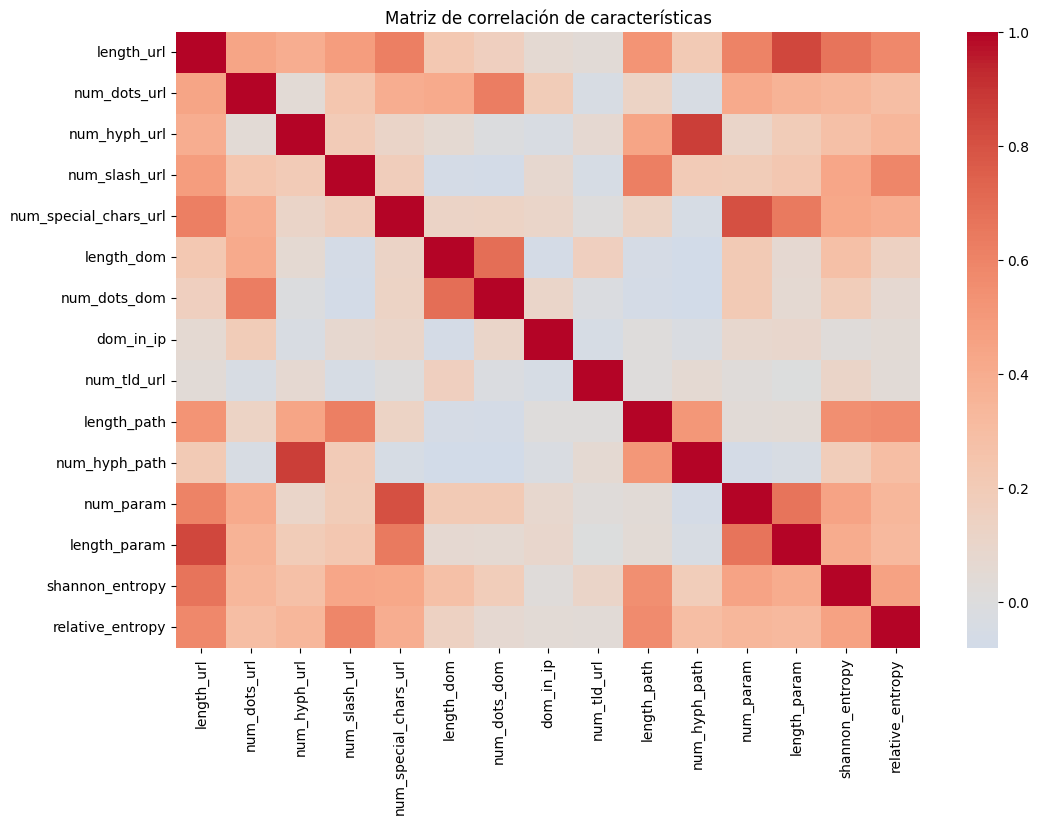

In [17]:
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), cmap="coolwarm", center=0)
plt.title("Matriz de correlación de características")
plt.show()